In [1]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
with open('ecolime-new-reaction-names.txt', 'r') as infile:
    rxn_names = pandas.read_csv(infile, sep = '\t', header = None, index_col = 0)
# rxn_names.index

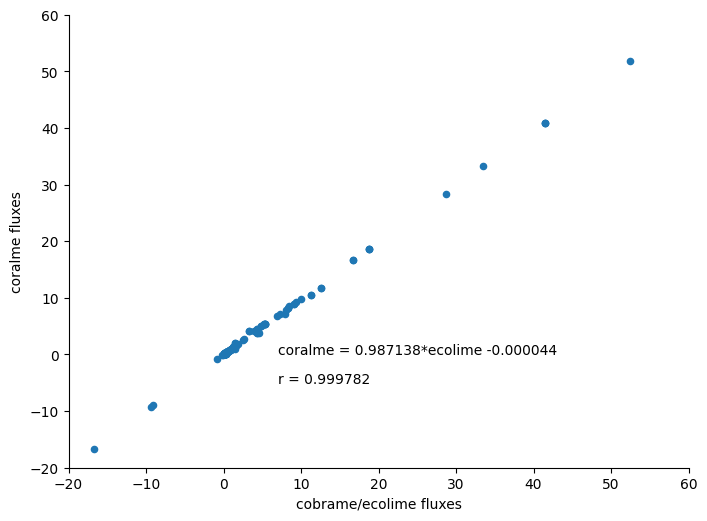

In [4]:
with open('coralme-fluxes-from-model.txt', 'r') as infile:
    target = pandas.read_csv(infile, sep = '\t', header = None, index_col = 0)
    
dct = { x:x.replace('_Outer_Membrane', '').replace('_Inner_Membrane', '').replace('_Periplasm', '')
       for x in target.index if x.startswith('translocation') }
target.index = [ dct.get(x, x) for x in target.index ]
    
target.columns = ['coralme fluxes']
target

with open('ecolime-fluxes-from-model.txt', 'r') as infile:
    source = pandas.read_csv(infile, sep = '\t', header = None, index_col = 0)

source.columns = ['cobrame/ecolime fluxes']
source.index = rxn_names.index

tmp = pandas.concat([source['cobrame/ecolime fluxes'], target['coralme fluxes']], axis = 1).dropna(how = 'any')
fig, ax = plt.subplots(1, 1, figsize = (4*2, 3*2), dpi = 100)
tmp.plot(kind = 'scatter', x = 0, y = 1, ax = ax)

# tmp = tmp[tmp.isnull().any(axis=1)].fillna(0)
# tmp[tmp['cobrame/ecolime'] != 0]
# tmp = tmp[(tmp['cobrame/ecolime'] != 0) | (tmp['coralme'] != 0)]

tmp[~tmp.index.str.startswith('transcription_') & ~tmp.index.str.startswith('translocation_')].to_csv('mismatching_reactions.txt', sep = '\t')
tmp[tmp.index.str.startswith('transcription_')].to_csv('mismatching_reactions_transcription_only.txt', sep = '\t')
tmp[tmp.index.str.startswith('translocation_')].to_csv('mismatching_reactions_translocation_only.txt', sep = '\t')

tmp = pandas.concat([source['cobrame/ecolime fluxes'], target['coralme fluxes']], axis = 1).dropna(how = 'any')
from scipy.stats import ttest_ind, linregress
res = linregress(tmp.iloc[:, 0], tmp.iloc[:, 1])
res

try:
    plt.text(7, -5, 'r = {:f}'.format(res[2]))
    plt.text(7, 0, 'coralme = {:f}*ecolime {:f}'.format(res[0], res[1]))
except:
    print('run again...')
    
plt.xlim(-20, 60)
plt.ylim(-20, 60)

seaborn.despine()

plt.savefig('flux_comparison_linear_regression.png', format = 'png', dpi = 300, edgecolor = 'w', facecolor = 'w')
plt.savefig('flux_comparison_linear_regression.svg', format = 'svg', dpi = 300, edgecolor = 'w', facecolor = 'w')
plt.show()

In [5]:
tmp[(tmp['cobrame/ecolime fluxes'] < 0) | (tmp['coralme fluxes'] < 0)]

,cobrame/ecolime fluxes,coralme fluxes
EX_cobalt2_e,-1.074998e-04,-1.038604e-04
EX_cu2_e,-2.581877e-06,-2.520805e-06
EX_fe2_e,-5.537101e-04,-5.426010e-04
EX_glc__D_e,-9.380408e+00,-9.252004e+00
EX_k_e,-4.347738e-05,-4.193061e-05
EX_mg2_e,-1.501063e-02,-1.458763e-02
EX_mn2_e,-4.987812e-05,-4.809533e-05
EX_nh4_e,-9.124461e+00,-8.961167e+00
EX_o2_e,-1.673140e+01,-1.662744e+01
EX_pi_e,-8.171414e-01,-7.989145e-01


In [6]:
tmp['Delta'] = abs(tmp['cobrame/ecolime fluxes']-tmp['coralme fluxes'])
# correct negative fluxes (demand/exchange reactions) to calculate log10
tmp['cobrame/ecolime fluxes'] = abs(tmp['cobrame/ecolime fluxes'])
tmp['coralme fluxes'] = abs(tmp['coralme fluxes'])

In [7]:
tmp['log cobrame/ecolime fluxes'] = tmp['cobrame/ecolime fluxes'].apply(numpy.log10)

In [8]:
tmp['log coralme fluxes'] = tmp['coralme fluxes'].apply(numpy.log10)

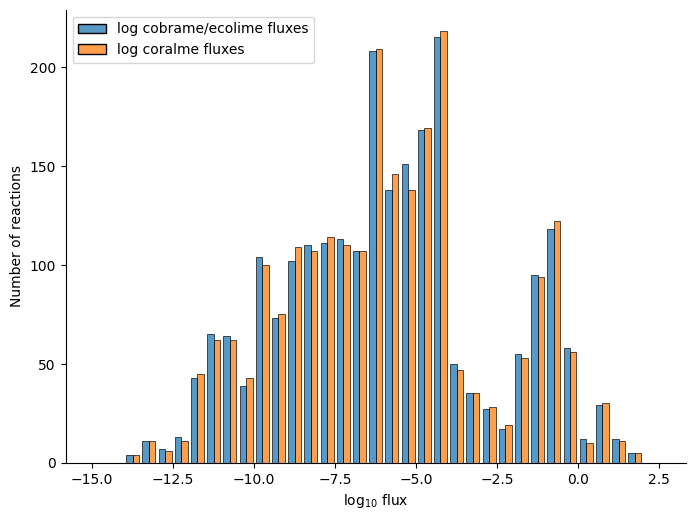

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (4*2, 3*2), dpi = 100)
seaborn.histplot(tmp[['log cobrame/ecolime fluxes', 'log coralme fluxes']], ax = ax, 
                multiple="dodge", shrink=.8, binrange = (-15, +2.5), binwidth = .5)#, element="step", fill=False, kde = True)

ax.set_xlabel(r'log$_{10}$ flux')
ax.set_ylabel('Number of reactions')

seaborn.despine()

plt.savefig('flux_comparison_histogram.png', format = 'png', dpi = 300, edgecolor = 'w', facecolor = 'w')
plt.savefig('flux_comparison_histogram.svg', format = 'svg', dpi = 300, edgecolor = 'w', facecolor = 'w')
plt.show()